# 1. Introduction

DTSA - 5511 Introduction to Deep Learning week 4 mini-project. 

The purpose of this project is to classify tweets into two different categories tweets about real disasters and those not about real disasters. The dataset is provided by Kaggle as part of a machine learning contest and includes a collection of tweets that have already been classified. 

## 1.1 Importing Libraries

In [57]:
# Import required libraries
from glob import glob 
import numpy as np
import pandas as pd
import keras,cv2,os
import matplotlib.pyplot as plt
import cv2
import gc
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import roc_curve, auc, roc_auc_score
from wordcloud import WordCloud, STOPWORDS
import spacy
import nltk
from nltk.tokenize import word_tokenize

import string
import itertools
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# 2. EDA

First step is to look at the dataset and perform some exploratory data analysis to see how the data is structured, what data is provided, and see what initial insights can be extracted. 

In [2]:
# Import data set
# set base directory this can be updated when run locally
path = '/kaggle/input/nlp-getting-started/'

# read test and train data

Test_df = pd.read_csv(path + 'test.csv')
Train_df = pd.read_csv(path + 'train.csv')
Train_df.head(5)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
len(Train_df)

7613

In [4]:
Train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


Initial looks at the data show 5 columns and 7613 rows of data. Data also contains some NaN values in the Keyword and Location column those will need to be dealt with before training the model. Now lets create some visualizations to dig deeper into the data. 

## 2.1 Visualizations

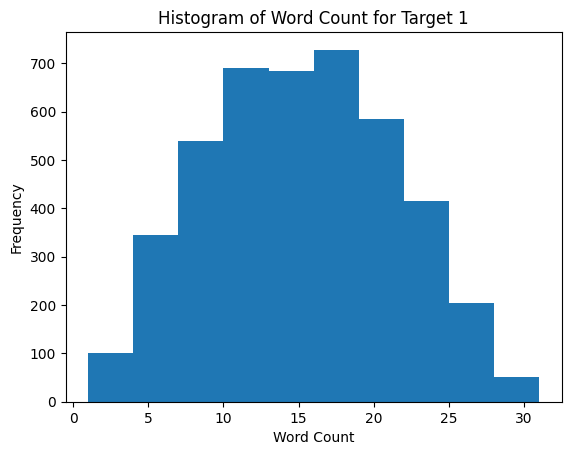

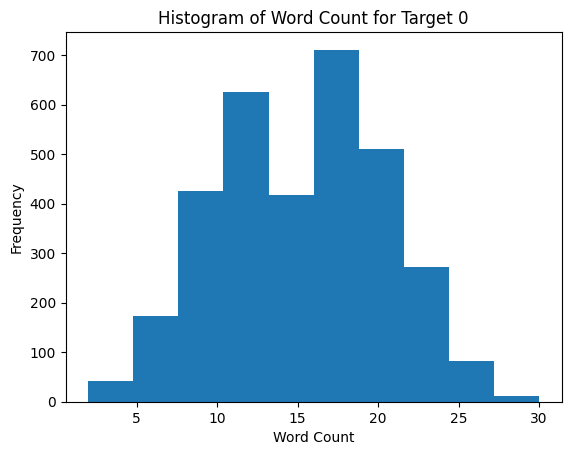

In [5]:
# frequency of word count by target
Train_df['Word Count'] = Train_df['text'].str.split().str.len()
filtered_df1 = Train_df[Train_df['target'] == 0]
filtered_df0 = Train_df[Train_df['target'] == 1]

# Create histogram
plt.hist(filtered_df1['Word Count'], bins=10)
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Histogram of Word Count for Target 1')
plt.show()

# Create histogram
plt.hist(filtered_df0['Word Count'], bins=10)
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Histogram of Word Count for Target 0')
plt.show()

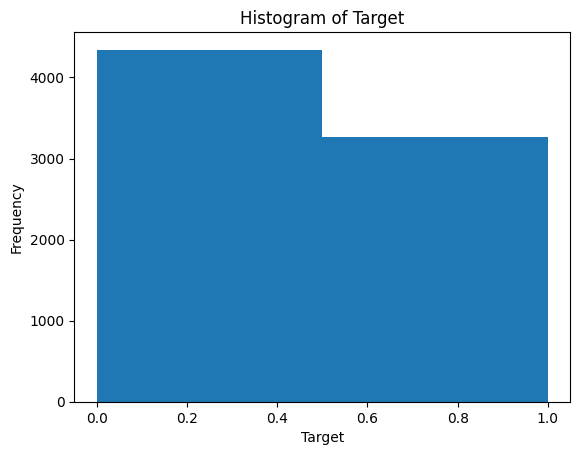

In [6]:
# distribution of target values
# Create histogram
plt.hist(Train_df['target'], bins=2)
plt.xlabel('Target')
plt.ylabel('Frequency')
plt.title('Histogram of Target')
plt.show()

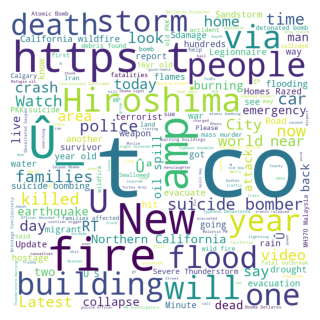

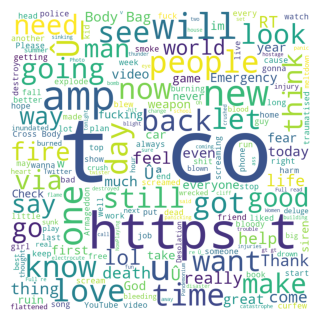

In [8]:
# generate word cloud 0
# Combine all text into a single string
text = ' '.join(filtered_df0['text'])

# Create a WordCloud object
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = STOPWORDS,
                min_font_size = 5).generate(text)

# Plot the WordCloud image                      
plt.figure(figsize = (3, 3), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

# generate word cloud 1
# Combine all text into a single string
text = ' '.join(filtered_df1['text'])

# Create a WordCloud object
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = STOPWORDS,
                min_font_size = 5).generate(text)

# Plot the WordCloud image                      
plt.figure(figsize = (3, 3), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

Initial look at the data there are clear differences in word usage and count between the two different target categories. Looking at the data the only column we need to keep is the actual text content. The keyword and location columns can be dropped and any NaN values they contained will no longer be an issue.  

## 2.2 Preprocessing/Cleaning

In [9]:
# Drop Columns
Train_df.drop(['location', 'keyword', 'Word Count'], axis=1, inplace=True) 
Test_df.drop(['location', 'keyword'], axis=1, inplace=True)
Train_df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      7613 non-null   int64 
 1   text    7613 non-null   object
 2   target  7613 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 178.6+ KB


After dopping unecessary columns we are ready to prepare text data for the model. In order to use the text we need to tokenize it prior to training. 

In [14]:
# tokenize text data
# load spacy model
nlp = spacy.load("en_core_web_sm")

Train_df['tokens'] = Train_df['text'].apply(lambda x: [token.text for token in nlp(x)])
Test_df['tokens'] = Test_df['text'].apply(lambda x: [token.text for token in nlp(x)])

In [15]:
# Create a vocabulary and map words to indices
vocab = set()
for tokens in Train_df['tokens']:
    vocab.update(tokens)
word_to_index = {word: index + 1 for index, word in enumerate(vocab)}

# Convert tokenized text to sequences of indices
def text_to_sequences(tokens):
    return [word_to_index[word] for word in tokens]

Train_df['sequences'] = Train_df['tokens'].apply(text_to_sequences)

# Pad sequences to a fixed length
max_length = max(len(seq) for seq in Train_df['sequences'])
X_train = pad_sequences(Train_df['sequences'], maxlen=max_length)
y_train = Train_df['target']

In [16]:
# Create a vocabulary and map words to indices
vocab = set()
for tokens in Test_df['tokens']:
    vocab.update(tokens)
word_to_index = {word: index + 1 for index, word in enumerate(vocab)}

Test_df['sequences'] = Test_df['tokens'].apply(text_to_sequences)

# Pad sequences to a fixed length
X_test = pad_sequences(Test_df['sequences'], maxlen=max_length)

# 3. Model 

## 3.1 Model Design

After performing some EDA and preprocessing the text data into tokens we are now ready to build our model. 

Since the text has been tokenized we will build our RNN model into 3 layers. Layer 1 will be an Embedding layer to convert our tokens into vectors. Layer 2 will be the LSTM layer to extract initial features. Layer 3 will be a dense layer to abstract more features. Last the output layer will generate a binary target value.  



## 3.2 Model Build

In [17]:
# Parameters
word_size = len(vocab) + 1  # Size of your vocabulary
maxlen = max_length
embedding_dim = 32  # Dimension of the word embeddings
LSTM_dim = 64  # Number of LSTM units
Dense_dim = 64  # Number of output classes (adjust as needed)
epoch = 10
batch = 32
dropout_conv = 0.5
model = Sequential()

In [18]:
# Layer 1 - Embeddings
model.add(Embedding(word_size, embedding_dim))

# Layer 2 - LSTM
model.add(LSTM(LSTM_dim))

# Layer 3 - Dense
model.add(Dense(Dense_dim, activation='relu'))
model.add(Dropout(dropout_conv))
# Layer 4 - Output
model.add(Dense(units=1, activation='sigmoid'))

model.build(input_shape=(None, maxlen))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 79, 32)         │       481,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 510,369 (1.95 MB)

 Trainable params: 510,369 (1.95 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
num_validation_samples = round(0.3 * len(X_train))

seq_train = X_train[num_validation_samples:]
labels_train = Train_df['target'].values[num_validation_samples:]
seq_validate = X_train[:num_validation_samples]
labels_validate = Train_df['target'].values[:num_validation_samples]

In [20]:
# Fit Model
hist = model.fit(seq_train, labels_train, validation_data=(seq_validate, labels_validate), epochs=epoch, batch_size=batch)

Epoch 1/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.5833 - loss: 0.6711 - val_accuracy: 0.6795 - val_loss: 0.6107
Epoch 2/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8124 - loss: 0.4271 - val_accuracy: 0.7176 - val_loss: 0.5662
Epoch 3/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9048 - loss: 0.2634 - val_accuracy: 0.6992 - val_loss: 0.6198
Epoch 4/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9491 - loss: 0.1527 - val_accuracy: 0.6830 - val_loss: 0.7707
Epoch 5/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9624 - loss: 0.1143 - val_accuracy: 0.7023 - val_loss: 0.8584
Epoch 6/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9730 - loss: 0.0770 - val_accuracy: 0.6786 - val_loss: 0.9775
Epoch 7/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9769 - loss: 0.0683 - val_accuracy: 0.6392 - val_loss: 1.1931
Epoch 8/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9806 - loss: 0.0541 - val_accuracy: 0.

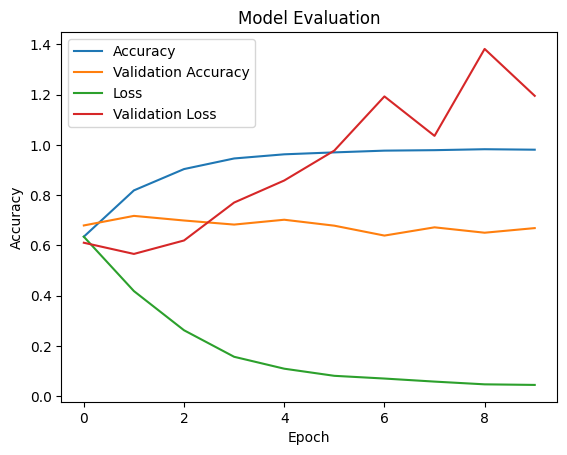

In [21]:
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

plt.title("Model Evaluation")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","Loss","Validation Loss"])

plt.show()

238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


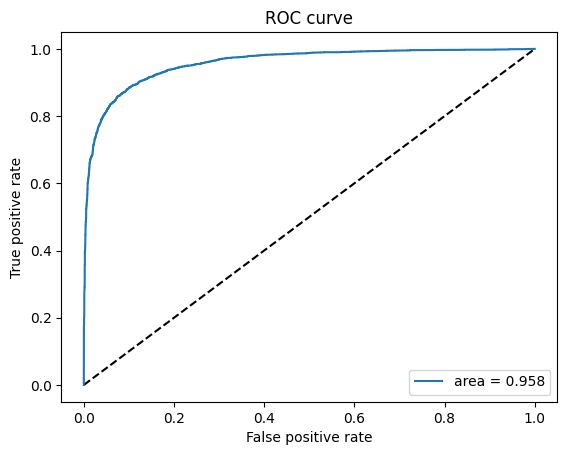

In [22]:
y_pred = model.predict(X_train)
fpr, tpr, thresholds = roc_curve(y_train, y_pred)
auc_train = auc(fpr, tpr)

# Plot ROC Curve

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='area = {:.3f}'.format(auc_train))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

The initial model scored a pretty terrible .49157 when submitted to kaggle. This mixed with the high accuracy of the training data tells me we are extremely overfitted. Next we will tune a model parameters to hopefully increase our score.

## 3.3 Fine Tuning

For fine tuning the model I manually changed several different parameters and tried different model architecture. I built wider and deeper networks and changed batch size, learning rate, and number of epochs. I really struggled with overfitting my model and focused on validation score and validation loss. I found the most helpful changes to the model architecure were creating a deeper (more layers) LSTM layer and a wider (more dimension) embedding layer contributed the most. I also tried different dense layers and did not find a real advantage and only more overfitting. For parameters the most helpful changes were reducing batch size and decreasing learning rate. 

In [50]:
# Parameters
word_size = len(vocab) + 1  # Size of your vocabulary
maxlen = max_length
embedding_dim = 1024  # Dimension of the word embeddings
LSTM_dim1 = 64  # Number of LSTM units
LSTM_dim2 = 64
LSTM_dim3 = 32
Dense_dim1 = 32  # Number of output classes (adjust as needed)
Dense_dim2 = 32
rate = .00001
epoch = 15
batch = 8
dropout_conv = 0.3
model = Sequential()

In [51]:
# Layer 1 - Embeddings
model.add(Embedding(word_size, embedding_dim))

# Layer 2 - LSTM
model.add(LSTM(LSTM_dim1, return_sequences=True))
model.add(Dropout(dropout_conv))
# Layer 3 - LSTM
model.add(LSTM(LSTM_dim2,return_sequences=True))
model.add(Dropout(dropout_conv))
# Layer 3 - LSTM
model.add(LSTM(LSTM_dim2,return_sequences=True))
model.add(Dropout(dropout_conv))
# Layer 3 - LSTM
model.add(LSTM(LSTM_dim3))
model.add(Dropout(dropout_conv))
# Layer 4 - Dense
model.add(Dense(Dense_dim1, activation='mish'))
model.add(Dropout(dropout_conv))

# Layer 5 - Dense
#model.add(Dense(Dense_dim2, activation='mish'))
#model.add(Dropout(dropout_conv))

# Layer 5 - Output
model.add(Dense(units=1, activation='sigmoid'))

model.build(input_shape=(None, maxlen))

model.compile(optimizer=keras.optimizers.Adam(rate), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ (None, 79, 1024)       │    15,401,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_29 (LSTM)                  │ (None, 79, 64)         │       278,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 79, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_30 (LSTM)                  │ (None, 79, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 79, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_31 (LSTM)                  │ (None, 79, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 79, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_32 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,760,321 (60.12 MB)

 Trainable params: 15,760,321 (60.12 MB)

 Non-trainable params: 0 (0.00 B)

In [52]:
# Fit Model
hist = model.fit(seq_train, labels_train, validation_data=(seq_validate, labels_validate), epochs=epoch, batch_size=batch)

Epoch 1/15
667/667 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.5418 - loss: 0.6920 - val_accuracy: 0.6195 - val_loss: 0.6822
Epoch 2/15
667/667 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - accuracy: 0.5440 - loss: 0.6886 - val_accuracy: 0.6195 - val_loss: 0.6738
Epoch 3/15
667/667 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - accuracy: 0.5537 - loss: 0.6842 - val_accuracy: 0.6182 - val_loss: 0.6721
Epoch 4/15
667/667 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - accuracy: 0.5453 - loss: 0.6838 - val_accuracy: 0.6182 - val_loss: 0.6671
Epoch 5/15
667/667 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - accuracy: 0.5629 - loss: 0.6742 - val_accuracy: 0.6296 - val_loss: 0.6621
Epoch 6/15
667/667 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - accuracy: 0.6424 - loss: 0.6544 - val_accuracy: 0.6563 - val_loss: 0.6300
Epoch 7/15
667/667 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - accuracy: 0.7136 - loss: 0.6100 - val_accuracy: 0.6926 - val_loss: 0.6265
Epoch 8/15
667/667 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - accuracy: 0.7530 - loss: 0.5792 - 

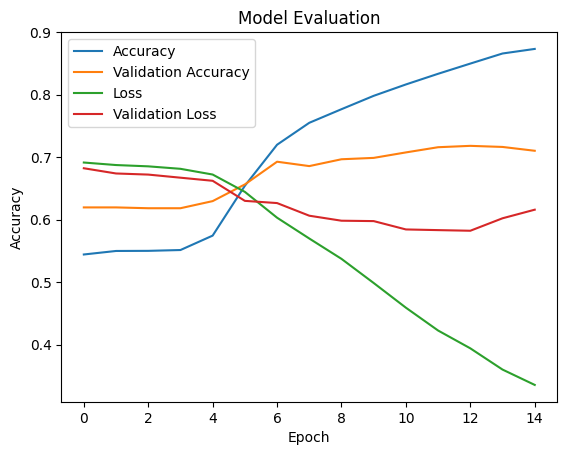

In [53]:
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

plt.title("Model Evaluation")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","Loss","Validation Loss"])

plt.show()

238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


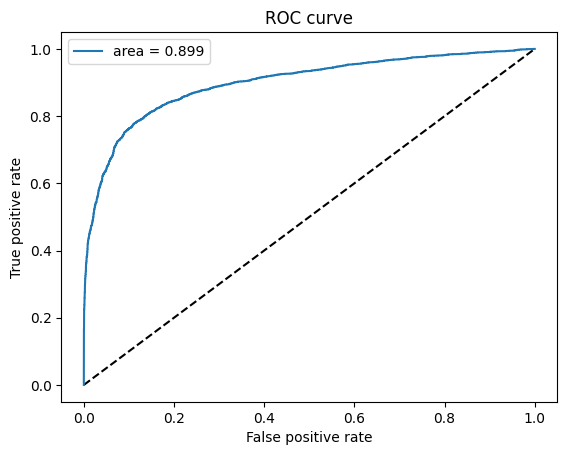

In [54]:
y_pred = model.predict(X_train)
fpr, tpr, thresholds = roc_curve(y_train, y_pred)
auc_train = auc(fpr, tpr)

# Plot ROC Curve

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='area = {:.3f}'.format(auc_train))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

## 3.4 Alternative Models

For an alternative model I will create a simple KNN model. It will be just a vanilla model with no fine tuning, calculate our training accuracy and then create a submission using the test data. 

In [82]:
# Basic KNN model

knn_model = KNeighborsClassifier(n_neighbors = 2)
knn_model.fit(X_train,y_train)

y_pred_knn = knn_model.predict(X_train)

knn_acc_train = accuracy_score(y_pred_knn,y_train)
knn_acc_train

0.7942992250098516

In [83]:
y_pred = knn_model.predict(X_test)

The KNN model achieved an accuracy of .794 on the training data and a final score of .54704 on the submission.

# 4. Results/Analysis

I created 3 different submissions, Initial model, tuned model, and alternative KNN model. 

The initial model achieved a final submitted score of .49157

The tuned model achieved a final submitted score of .50076

And the KNN model achieved a final submitted score of .54704

In [55]:
# create submission from test data
y_pred = model.predict(X_test)

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [85]:
# Generate submission
Test_df['target'] = y_pred
submission = Test_df[["id", "target"]].copy()
submission['target'] = submission['target'].map(lambda x: 1 if x > 0.5 else 0)
submission.head()
submission.to_csv("submission-KNN.csv", index = False, header = True) #create the submission file

# 5. Conclusion

In conclusion we built 3 different models to classify tweets about real natural disasters. I performed EDA on the kaggle provided dataset, preprocessed the data into tokens, and then built an initial model. Overall the submitted scores were not much different and pretty terrible between .491 and .547. Submitted score did not seem to match the validation score I was using as a metric at all. 



